# Price Prediction using Technical Indicators

## Data Acquisition

It's currently possible to source daily stock data from Yahoo Finance, so we're using the `yfinance` python library.

When acquiring data, we don't want to throw out samples for no reason - chances are we'll use the data more than once to test out different approaches. Instead, we will store each sample in a datastore. MongoDB fits the use case pretty well:

- The primary access pattern is grabbing a sequence of samples for a given ticker(s) within a specific time range. This is easy with Mongo's index feature, and SQL would be overkill.
- We plan on adding and removing features / attributes / columns regularly, which could be a pain with SQL.

In [143]:
import numpy as np
import pandas as pd
from datetime import datetime

# Set the start and end date
start_date = '2005-01-01'
end_date = '2022-06-16'

In [145]:
import numpy as np
import pandas as pd
import yfinance as yf
from pymongo import MongoClient
from datetime import datetime

mongo = MongoClient()
db = mongo.stock_analysis

#spy_constituents = pd.read_csv('../data/spy_constituents.csv')

# Set the tickers
tickers = ['VTI', 'SPY']

for ticker in tickers:
    print(ticker)
    # Get the data
    data = yf.download(ticker, start_date, end_date)
    
    # Clean and format data
    data['date'] = data.index.values.astype("datetime64[ns]")
    data.rename(columns = {
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'adj_close',
        'Volume': 'volume'
    }, inplace = True)
    data['symbol'] = ticker

    # Insert into mongo
    if not data.empty:
        db.daily_samples.insert_many(data.to_dict('records'))
    
mongo.close()

VTI
[*********************100%***********************]  1 of 1 completed
SPY
[*********************100%***********************]  1 of 1 completed


## Pulling Data from Datastore

In [311]:
from pymongo import MongoClient

mongo = MongoClient()
db = mongo.stock_analysis

ticker = 'AMZN'
# Pull all samples within range
cur = db.daily_samples.find({
    'symbol': { '$eq': ticker },
    'date': { '$gt': datetime.fromisoformat(start_date), '$lt': datetime.fromisoformat(end_date) }
})
data = pd.DataFrame([sample for sample in cur])

mongo.close()

data

,_id,open,high,low,close,adj_close,volume,date,symbol
0,62ab62e88ccf184846c58cfd,6.812500,6.830500,6.657000,6.695000,6.695000,151998000,2010-01-04,AMZN
1,62ab62e88ccf184846c58cfe,6.671500,6.774000,6.590500,6.734500,6.734500,177038000,2010-01-05,AMZN
2,62ab62e88ccf184846c58cff,6.730000,6.736500,6.582500,6.612500,6.612500,143576000,2010-01-06,AMZN
3,62ab62e88ccf184846c58d00,6.600500,6.616000,6.440000,6.500000,6.500000,220604000,2010-01-07,AMZN
4,62ab62e88ccf184846c58d01,6.528000,6.684000,6.451500,6.676000,6.676000,196610000,2010-01-08,AMZN
...,...,...,...,...,...,...,...,...,...
3130,62ab62e88ccf184846c59937,119.989998,121.300003,116.099998,116.150002,116.150002,67029800,2022-06-09,AMZN
3131,62ab62e88ccf184846c59938,113.419998,114.500000,109.050003,109.650002,109.650002,87266000,2022-06-10,AMZN
3132,62ab62e88ccf184846c59939,104.190002,106.540001,101.860001,103.669998,103.669998,99277700,2022-06-13,AMZN
3133,62ab62e88ccf184846c5993a,104.190002,104.879997,101.430000,102.309998,102.309998,69728800,2022-06-14,AMZN


## Feature, label calculation

We'll add some select technical indicator features from the `ta` python library, along with some custom indicators.

- % change since yesterday
- % change since two days ago
- % change since 3 days ago
- ... etc.
- % change since a week ago
- % change since a month ago
- Company sector (how to encode, data source)?

In [312]:
import ta

def percent_change(data, window=1, track_feature="close"):
    return (data[track_feature].shift(-window) - data[track_feature]) / data[track_feature] * 100

def add_technical_indicators(signals, data):
    signals["rsi7"] = ta.momentum.RSIIndicator(data["close"], window=7).rsi()
    signals["rsi14"] = ta.momentum.RSIIndicator(data["close"], window=14).rsi()
    signals["rsi30"] = ta.momentum.RSIIndicator(data["close"], window=30).rsi()
    signals["kama"] = ta.momentum.KAMAIndicator(data["close"]).kama()
    signals["percent_price"] = ta.momentum.PercentagePriceOscillator(data["close"]).ppo()
    signals["ema"] = ta.trend.EMAIndicator(data["close"]).ema_indicator()
    signals["stoch_rsi"] = ta.momentum.StochRSIIndicator(data["close"]).stochrsi()
    signals["avg_true_range"] = ta.volatility.AverageTrueRange(data["high"], data["low"], data["close"]).average_true_range()
    bollinger = ta.volatility.BollingerBands(data["close"])
    signals["bollinger_high"] = bollinger.bollinger_hband()
    signals["bollinger_low"] = bollinger.bollinger_lband()
    signals["bollinger_avg"] = bollinger.bollinger_mavg()
    signals["pchange_-1day"] = percent_change(data, window=-1)
    signals["pchange_-2day"] = percent_change(data, window=-2)
    signals["pchange_-3day"] = percent_change(data, window=-3)
    signals["pchange_-7day"] = percent_change(data, window=-7)
    signals["pchange_-14day"] = percent_change(data, window=-14)
    signals["pchange_-30day"] = percent_change(data, window=-30)
    # TODO MANY MORE INDICATORS
    return signals

def create_signals(data, predict_window):
    # Create df, add technical indicators
    signals = add_technical_indicators(pd.DataFrame(), data)
    # Add label column
    label_key = f'pchange_{predict_window}day'
    signals[label_key] = percent_change(data, window=predict_window)
    return signals

label_key = f'pchange_{14}day'
signals = create_signals(data, 14)
signals

,rsi7,rsi14,rsi30,kama,percent_price,ema,stoch_rsi,avg_true_range,bollinger_high,bollinger_low,bollinger_avg,pchange_-1day,pchange_-2day,pchange_-3day,pchange_-7day,pchange_-14day,pchange_-30day,pchange_14day
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.149366
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,-0.586528,NaN,NaN,NaN,NaN,NaN,-11.292597
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1.844987,1.247637,NaN,NaN,NaN,NaN,-7.183370
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,1.730772,3.607691,3.000003,NaN,NaN,NaN,-3.053849
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,-2.636311,-0.951167,0.876270,NaN,NaN,NaN,-6.073995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130,43.597216,44.866237,42.868170,119.261826,-1.301617,118.465813,0.572775,5.509154,128.156075,100.615676,114.385875,4.330606,5.897545,7.438656,3.495051,-7.603100,18.955666,NaN
3131,32.370270,38.935030,40.203849,119.185770,-1.816190,117.290372,0.343199,5.622785,128.046406,100.997295,114.521851,5.927952,10.515275,12.175101,10.974917,-1.877791,31.870948,NaN
3132,25.360603,34.426003,37.958558,118.209367,-2.616895,115.474322,0.168672,5.777587,128.375835,99.729366,114.052600,5.768307,12.038202,16.890135,21.067815,3.749398,19.881840,NaN
3133,23.982656,33.476482,37.466285,115.823385,-3.325328,113.719079,0.000000,5.611330,128.790291,98.464859,113.627575,1.329294,7.174278,13.527519,19.587529,1.749586,21.688987,NaN


## Data Cleaning

- Handle nans
- Feature scaling
- To numpy arrays

In [313]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def signals_to_X(signals):
    X_scaler = StandardScaler()

    # Remove label, remove nans, to numpy
    features = signals.loc[:, signals.columns != label_key].dropna().to_numpy()
    # Scale
    features = X_scaler.fit_transform(features)
    return features

def signals_to_Xy(signals):
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    # Remove nans
    # TODO TRY FILLING?
    features = signals.dropna()
    # Pull out labels and features
    labels = y_scaler.fit_transform(features[label_key].to_numpy().reshape(-1, 1))[:, 0]
    features = features.loc[:, features.columns != label_key].to_numpy()
    # Scale
    features = X_scaler.fit_transform(features)
    return features, labels

# Split features and labels into train and test
features, labels = signals_to_Xy(signals)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1)
X_test

array([[-0.43192678, -0.56083814, -0.93260869, ...,  0.70782794,
        -0.84133403,  0.63889181],
       [-0.25749243, -0.79703277, -1.08268921, ...,  0.2649714 ,
         0.41914104,  1.35107154],
       [-1.51629242, -1.62995438, -1.28608032, ...,  2.60421033,
         1.67476928,  1.06075333],
       ...,
       [-0.78873779, -1.17186092, -1.14738887, ...,  0.21744811,
         0.86163452,  1.51829219],
       [-1.74770585, -1.76141625, -1.94618393, ...,  2.94193844,
         1.11177693,  2.78258087],
       [ 0.25057828, -0.26320618, -0.7185439 , ..., -0.45500221,
         0.20184054,  0.42074961]])

## Signal Model

This model will take in various daily signals about a specific asset (technical indicators, sentiment, etc. mostly normalized data), and output predicted percent change in the specified period.

(2781, 17)
Correctly predicted direction of change 86.45161290322581% of the time
Up 56.451612903225815% of the time
MSE Loss: 0.3230901243041457
Standard deviation: actual = 1.0024272628097368, predicted = 0.6102164169066946


<IPython.core.display.Javascript object>


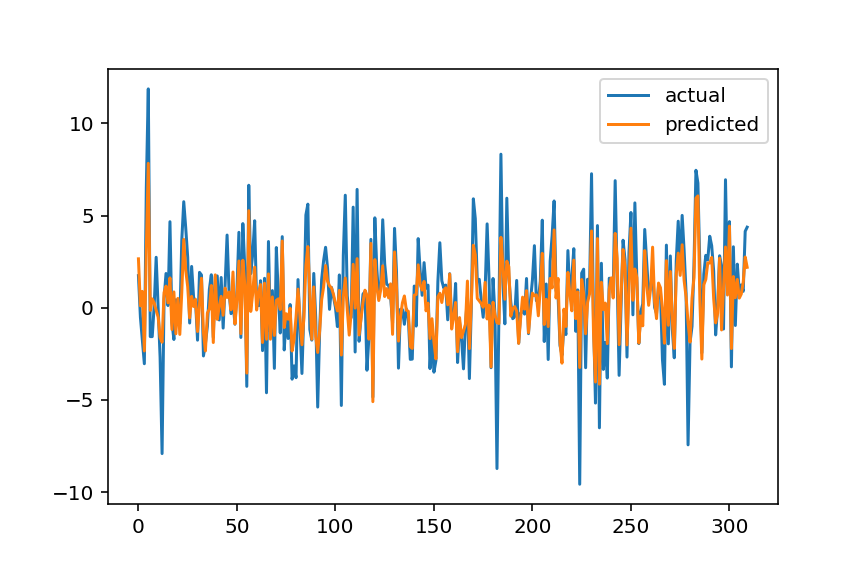

In [315]:
# TODO
%matplotlib notebook
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, RidgeCV, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

# The following models correctly predicted 14-day direction of change ~60% of the time,
# with MLPRegressor generally being the strongest.
#params_grid = {'kernel': ['rbf',],'C': [1, 10, 100, 1000],'gamma': [0.1, 0.01, 0.001, 0.0001]}
#signal_model = GridSearchCV(SVR(), params_grid, refit=True, verbose=3)
#signal_model = SVR()
#signal_model = LinearRegression()
#signal_model = SGDRegressor()
#signal_model = RidgeCV()
#signal_model = MLPRegressor(max_iter=1000, tol=1e-5)

# Decision trees and random forests give us about 80% accuracy in
# predicting 14-day direction of change. Magnitude is not perfect.
signal_model = RandomForestRegressor()
#signal_model = AdaBoostRegressor(base_estimator=signal_model)
#signal_model = VotingRegressor([('svr', SVR()), ('linreg', LinearRegression()), ('mlp', MLPRegressor(max_iter=1000, tol=1e-5)), ('forest', RandomForestRegressor())], weights=[0.1, 0.1, 0.1, 0.7])

# Train
signal_model.fit(X_train, y_train)

# Test
def test_model(model, X_test, y_test):
    # Predict
    y_predicted = model.predict(X_test)
    # Error and % correct
    loss = np.mean(np.square(y_predicted - y_test))
    correct = ((y_predicted > 0) == (y_test > 0)).sum() / len(y_predicted) * 100
    up = (y_test > 0).sum() / len(y_test) * 100
    print(f'Correctly predicted direction of change {correct}% of the time')
    print(f'Up {up}% of the time')
    print('MSE Loss:', loss)
    print(f'Standard deviation: actual = {np.std(y_test)}, predicted = {np.std(y_predicted)}')
    # Plot of percent change
    y_test = y_scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]
    y_predicted = y_scaler.inverse_transform(y_predicted.reshape(-1, 1))[:, 0]
    fig, ax=plt.subplots(dpi=72*2)
    ax.plot(np.arange(len(y_test)), y_test, label="actual")
    ax.plot(np.arange(len(y_predicted)), y_predicted, label="predicted")
    ax.legend()
    plt.show()

test_model(signal_model, X_test, y_test)

## Validating the previous results, training with more data

We got an 80%+ accuracy rate in determining future direction of stock prices a few weeks out.

- Make concrete price prediction for many big name tickers, record predictions, and keep track over the next few weeks.
  - Make paper trades based on the info.
  - Function `predict_future_prices(data)` takes the raw prices data, computes the technical signals, plots the predicted future prices, returns predictions.
- Concern: are errors clustered together? Do they occur at the same time for different assets? Error matrix, with regression output bound into categories: large loss, small loss, little change, small win, big win.
- Dummy trading bot.

If all these tests pass, and the results still seem useful, we will begin training with data from multiple stocks, after clustering them, either manually or with a clustering model, by market cap, industry, other fundamentals data, age of company, etc.

(14, 18)


<IPython.core.display.Javascript object>


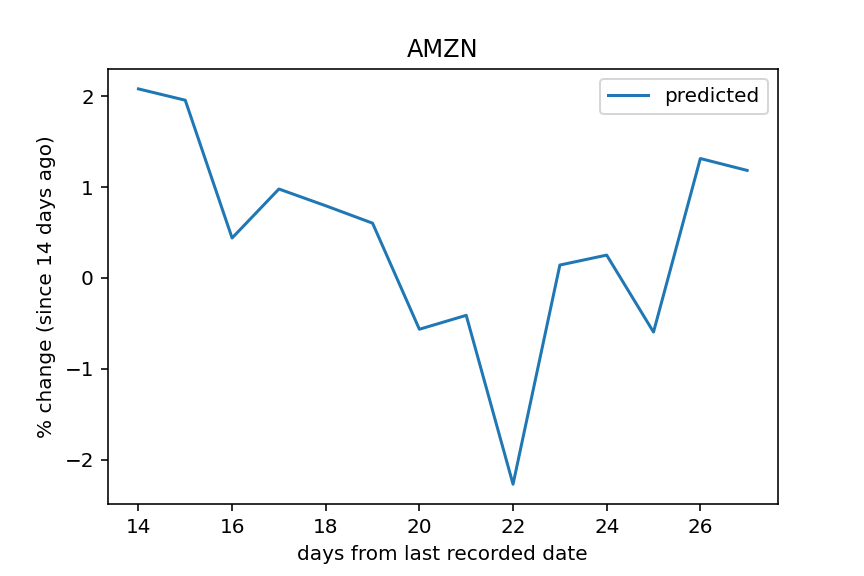

In [310]:
def predict_future_changes(model, signals):
    unlabeled_signals = signals[np.isnan(signals[label_key])]
    print(unlabeled_signals.shape)
    features = signals_to_X(unlabeled_signals)
    y_predicted = model.predict(features)
    
    # Plot of percent change
    y_predicted = y_scaler.inverse_transform(y_predicted.reshape(-1, 1))[:, 0]
    fig, ax=plt.subplots(dpi=72*2)
    ax.plot(np.arange(14, len(y_predicted) + 14), y_predicted, label="predicted")
    plt.title(ticker)
    plt.xlabel("days from last recorded date")
    plt.ylabel("% change (since 14 days ago)")
    ax.legend()
    plt.show()
    
predict_future_changes(signal_model, signals)